# **Auto tag the tickets with right priorities and right departments**

## Import necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
from collections import Counter 
from sklearn.preprocessing import LabelEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,f1_score

### Loading The dataset

In [3]:
data = pd.read_csv("C:\\Users\suchi\CDS Internship Datamites\ITSM_data.csv")
data.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,incident,KM0000553,closed,26.0,05-02-2012 13:32,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,incident,KM0000611,closed,33.0,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,request for information,KM0000339,closed,3.0,29-03-2012 12:36,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,incident,KM0000611,closed,13.0,17-07-2012 11:49,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,incident,KM0000611,closed,2.0,10-08-2012 11:01,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


* As the above datetime columns are not in right format so pandas reads that column as object so we have to convert first those column into datetime.


In [4]:
data['Close_Time'] = pd.to_datetime(data['Close_Time'] ,format='mixed' )

In [5]:
data['Open_Time'] = pd.to_datetime(data['Open_Time'] ,format='mixed' )

In [6]:
data['Reopen_Time'] = pd.to_datetime(data['Reopen_Time'] ,format='mixed' )

In [7]:
data['Resolved_Time'] = pd.to_datetime(data['Resolved_Time'] ,format='mixed' )

In [8]:
data.head(2)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,incident,KM0000553,closed,26.0,2012-05-02 13:32:00,NaT,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,incident,KM0000611,closed,33.0,2012-12-03 15:44:00,2013-02-12 12:31:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN


## Basic checks 

In [9]:
data.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,incident,KM0000553,closed,26.0,2012-05-02 13:32:00,NaT,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,incident,KM0000611,closed,33.0,2012-12-03 15:44:00,2013-02-12 12:31:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,request for information,KM0000339,closed,3.0,2012-03-29 12:36:00,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,incident,KM0000611,closed,13.0,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,incident,KM0000611,closed,2.0,2012-10-08 11:01:00,NaT,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [10]:
data.tail()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
46601,SBA000464,application,Server Based Application,WBS000073,IM0047053,Closed,4,4,4.0,0.231896,incident,KM0001314,closed,0.0,2014-03-31 16:23:00,NaT,2014-03-31 16:29:00,2014-03-31 16:29:00,"0,095",Other,1.0,SD0147021,NaN,NaN,NaN
46602,SBA000461,application,Server Based Application,WBS000073,IM0047054,Closed,4,4,4.0,0.805153,incident,KM0002360,closed,0.0,2014-03-31 15:03:00,NaT,2014-03-31 15:29:00,2014-03-31 15:29:00,"0,428333333",User error,1.0,SD0146967,NaN,NaN,NaN
46603,LAP000019,computer,Laptop,WBS000091,IM0047055,Closed,5,5,5.0,0.917466,incident,KM0000315,closed,0.0,2014-03-31 15:28:00,NaT,2014-03-31 15:32:00,2014-03-31 15:32:00,"0,071666667",Hardware,1.0,SD0146982,NaN,NaN,NaN
46604,WBA000058,application,Web Based Application,WBS000073,IM0047056,Closed,4,4,4.0,0.701278,incident,KM0001287,closed,0.0,2014-03-31 15:35:00,NaT,2014-03-31 15:42:00,2014-03-31 15:42:00,"0,116944444",Software,1.0,SD0146986,NaN,NaN,NaN
46605,DCE000077,hardware,DataCenterEquipment,WBS000267,IM0047057,Closed,3,3,3.0,0.902320,incident,KM0000182,closed,0.0,2014-03-31 17:24:00,NaT,2014-03-31 22:47:00,2014-03-31 22:47:00,"0,586388889",Hardware,1.0,SD0147088,NaN,NaN,NaN


#### Examine the data

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     46606 non-null  object        
 1   CI_Cat                      46495 non-null  object        
 2   CI_Subcat                   46495 non-null  object        
 3   WBS                         46606 non-null  object        
 4   Incident_ID                 46606 non-null  object        
 5   Status                      46606 non-null  object        
 6   Impact                      46606 non-null  object        
 7   Urgency                     46606 non-null  object        
 8   Priority                    45226 non-null  float64       
 9   number_cnt                  46606 non-null  float64       
 10  Category                    46606 non-null  object        
 11  KB_number                   46606 non-null  object    

#### Statistical measure of data

In [12]:
data.describe()

,Priority,number_cnt,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes
count,45226.000000,46606.000000,46605.000000,46606,2284,44826,46606,46492.000000,1222.000000,560.000000
mean,4.215805,0.499658,1.131831,2013-12-22 01:35:58.833626624,2013-12-19 15:54:41.847635968,2013-12-28 17:43:53.840182016,2013-12-28 08:05:15.215637248,1.149897,1.669394,1.058929
min,1.000000,0.000023,0.000000,2012-01-10 10:49:00,2013-01-10 09:58:00,2013-01-10 06:45:00,2013-01-10 06:45:00,1.000000,1.000000,1.000000
25%,4.000000,0.248213,0.000000,2013-10-22 11:24:15,2013-10-20 16:51:45,2013-10-25 17:15:00,2013-10-25 16:20:45,1.000000,1.000000,1.000000
50%,4.000000,0.500269,0.000000,2013-12-23 11:31:00,2013-12-17 10:31:00,2013-12-31 10:33:30,2013-12-31 08:43:00,1.000000,1.000000,1.000000
75%,5.000000,0.749094,2.000000,2014-03-01 10:46:15,2014-02-25 13:52:30,2014-03-13 10:39:45,2014-03-13 09:04:30,1.000000,1.000000,1.000000
max,5.000000,0.999997,46.000000,2014-12-03 22:58:00,2014-12-03 17:24:00,2014-12-03 17:56:00,2014-12-03 17:56:00,370.000000,63.000000,9.000000
std,0.705624,0.288634,2.269774,NaN,NaN,NaN,NaN,2.556338,3.339687,0.403596


* For the resolution of the of the we have to use No_of_Reassignments as output column.

### Checking for outliers

<Axes: >

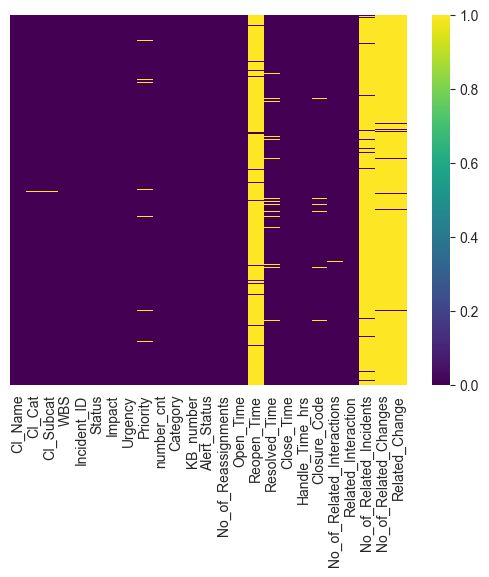

In [14]:
sns.set_style('whitegrid')
sns.heatmap(data.isnull(),yticklabels = False , cbar = True ,cmap = 'viridis')

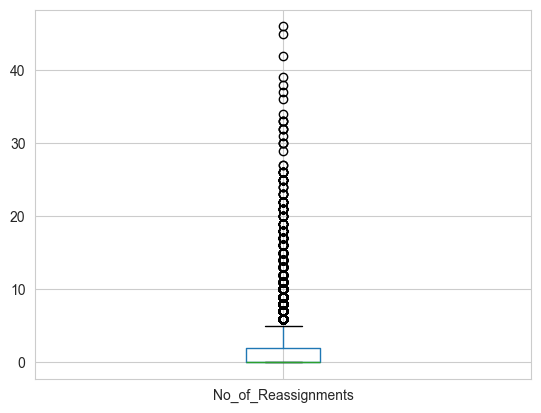

In [15]:
data[['No_of_Reassignments']].boxplot();

In [16]:
X= data.No_of_Reassignments

In [18]:
removed_outlier_Reassignment = X.between(X.quantile(0.7),X.quantile(0.9))

Text(0.5, 0, 'No_of_Reassignments')

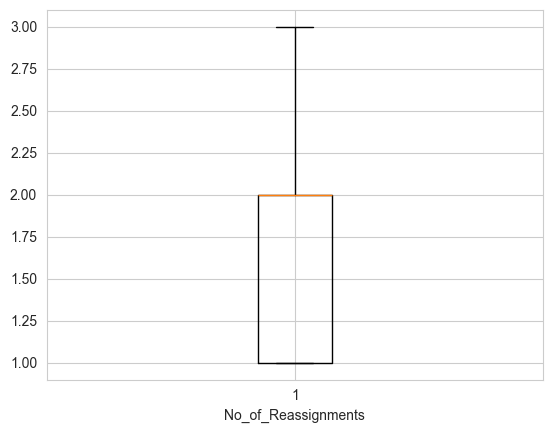

In [20]:
plt.boxplot(X[removed_outlier_Reassignment]);
plt.xlabel("No_of_Reassignments")


In [21]:
data['cleaned_reassignment'] = X[removed_outlier_Reassignment]

### Droping unique columns

In [23]:
data = data.drop(['Impact' , 'Urgency' ,'Alert_Status' , 'No_of_Reassignments' , 'Open_Time' , 'Reopen_Time','Resolved_Time' , 'Close_Time'] , axis = 1)

In [24]:
data.head(1)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Priority,number_cnt,Category,KB_number,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,cleaned_reassignment
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,0.601292,incident,KM0000553,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN,NaN


In [25]:
dataset=data.loc[:,['CI_Cat','CI_Subcat','WBS','Category']]
dataset.head()

,CI_Cat,CI_Subcat,WBS,Category
0,subapplication,Web Based Application,WBS000162,incident
1,application,Web Based Application,WBS000088,incident
2,application,Desktop Application,WBS000092,request for information
3,application,Web Based Application,WBS000088,incident
4,application,Web Based Application,WBS000088,incident


In [26]:
dataset.shape

(46606, 4)

In [27]:
dataset.isnull().sum()

CI_Cat       111
CI_Subcat    111
WBS            0
Category       0
dtype: int64

In [28]:
dataset.dropna(inplace = True)

In [29]:
dataset.isnull().sum()

CI_Cat       0
CI_Subcat    0
WBS          0
Category     0
dtype: int64

In [32]:
dataset.loc[data.cleaned_reassignment>4.0,'tickets']='high'
dataset.loc[(data.cleaned_reassignment>2.0)& (data.cleaned_reassignment<=4.0),'tickets']='medium'
dataset.loc[data.cleaned_reassignment<=2.0,'tickets']='low'

### Define x and y

In [33]:
X=dataset.loc[:,dataset.columns!='tickets']
y=dataset.tickets

In [34]:
y.isnull().sum()

31690

In [36]:
y.fillna(method = 'ffill' , inplace = True)

In [37]:
y.fillna(method= 'bfill' , inplace = True)

## Use label encoder

In [38]:
enc=LabelEncoder()

X.CI_Cat=enc.fit_transform(X.CI_Cat)
X.CI_Subcat=enc.fit_transform(X.CI_Subcat)
X.WBS=enc.fit_transform(X.WBS)
X.Category=enc.fit_transform(X.Category)

X.head()

,CI_Cat,CI_Subcat,WBS,Category
0,11,57,136,1
1,1,57,70,1
2,1,10,74,3
3,1,57,70,1
4,1,57,70,1


### Splittng the data

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=20,test_size=0.3)


In [40]:
print("X_train shape = ",X_train.shape)
print("X_test shape = ",X_test.shape)
print("y_train shape = ",y_train.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (32546, 4)
X_test shape =  (13949, 4)
y_train shape =  (32546,)
y_test shape =  (13949,)


# 1. Random Forest Classifier

In [41]:
model=RandomForestClassifier(n_estimators=300,random_state=10,max_depth=4,criterion='gini')
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, n_estimators=300, random_state=10)

In [42]:
y_train_predict=model.predict(X_train)
y_predict=model.predict(X_test)
print(accuracy_score(y_test,y_predict)*100)

84.83762276865725


In [43]:
y_train_predict=model.predict(X_train)
y_predict=model.predict(X_test)
print(accuracy_score(y_test,y_predict)*100)

84.83762276865725


In [44]:
pd.crosstab(y_test,y_predict)

col_0,low
tickets,
low,11834
medium,2115


In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_predict))

[[11834     0]
 [ 2115     0]]


In [47]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         low       0.85      1.00      0.92     11834
      medium       0.00      0.00      0.00      2115

    accuracy                           0.85     13949
   macro avg       0.42      0.50      0.46     13949
weighted avg       0.72      0.85      0.78     13949



* For the above data random forest model predict very well with model accuracy upto 85%

# 2. Using Xgboost

### standarize the data along X-axis

In [48]:
X=scale(X)

In [50]:
class_mapping = {'low': 0, 'medium': 1, }
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

In [52]:
model=XGBClassifier(max_depth=3,learning_rate=0.5,random_state=50,n_estimators=50)
model.fit(X_train,y_train_mapped)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=50, ...)

In [53]:
y_train_predict=model.predict(X_train)
y_predict=model.predict(X_test)

In [55]:
print("\nTrain accuracy = " ,accuracy_score(y_train_mapped,y_train_predict)*100)
print("\nTest accuracy = " ,accuracy_score(y_test_mapped,y_predict)*100)
print("\nPrecision score: {}".format(precision_score(y_test_mapped,y_predict,average='weighted')*100))
print("\nRecall score: {}".format(recall_score(y_test_mapped,y_predict,average='weighted')*100))
print("\nF1 score: {}".format(f1_score(y_test_mapped,y_predict,average='weighted')*100))



Train accuracy =  85.20555521415842

Test accuracy =  84.83045379597104

Precision score: 71.97330013059371

Recall score: 84.83045379597104

F1 score: 77.87476458160899


In [56]:
pd.crosstab(y_test_mapped,y_predict)

col_0,0,1
tickets,,
0,11833,1
1,2115,0


In [58]:
print(confusion_matrix(y_test_mapped,y_predict))

[[11833     1]
 [ 2115     0]]


In [59]:
print(classification_report(y_test_mapped,y_predict))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     11834
           1       0.00      0.00      0.00      2115

    accuracy                           0.85     13949
   macro avg       0.42      0.50      0.46     13949
weighted avg       0.72      0.85      0.78     13949



* This model predcit the model accuracy upto 77%